In [117]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from tqdm.notebook import tqdm
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


sys.path.append('../utils')
import helpers as h
import feature_engineering as f

load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\ortools\.libs\ortools.dll...


There was an interesting plot in our EDA phase; let's recreate it and use the heaviest squares as centroids.

In [2]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))
driven_df = request_df.query('request_day_route_is_last==True')

C:\Users\Frede\AppData\Local\Temp\ipykernel_6376\4069580357.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


## see if centroids move on daily basis: 

In [3]:
driven_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,Date,Time,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last
4,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,388,0.572716,0.233306,2022-06-17T07:30:00,2022-06-17T23:59:00,2,1,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 09:24:16.831000,34f409b3-9f92-4720-9926-48ca1cbf6f90,0521_300,FullOptimization,CreateSequence,2.0,0.0,3.0,True
5,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,390,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,2022-06-17 00:00:00,1900-01-01 09:24:16.831000,34f409b3-9f92-4720-9926-48ca1cbf6f90,0521_300,FullOptimization,CreateSequence,2.0,0.0,3.0,True
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,2022-05-30 00:00:00,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120926,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63699,0.480072,0.301707,2022-06-22T07:30:00,2022-06-22T23:59:00,135,135,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120927,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63698,0.479680,0.301925,2022-06-22T07:30:00,2022-06-22T23:59:00,136,136,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120928,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63697,0.479792,0.300703,2022-06-22T07:30:00,2022-06-22T23:59:00,137,137,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True
2120929,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,63696,0.481527,0.300490,2022-06-22T07:30:00,2022-06-22T23:59:00,138,138,0521_O69-20220622,...,2022-06-22 00:00:00,1900-01-01 08:38:33.987000,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,0521_O69,TimeCalculation,EstimateTime,139.0,139.0,5.0,True


In [7]:
driven_df.route_id.nunique()

232

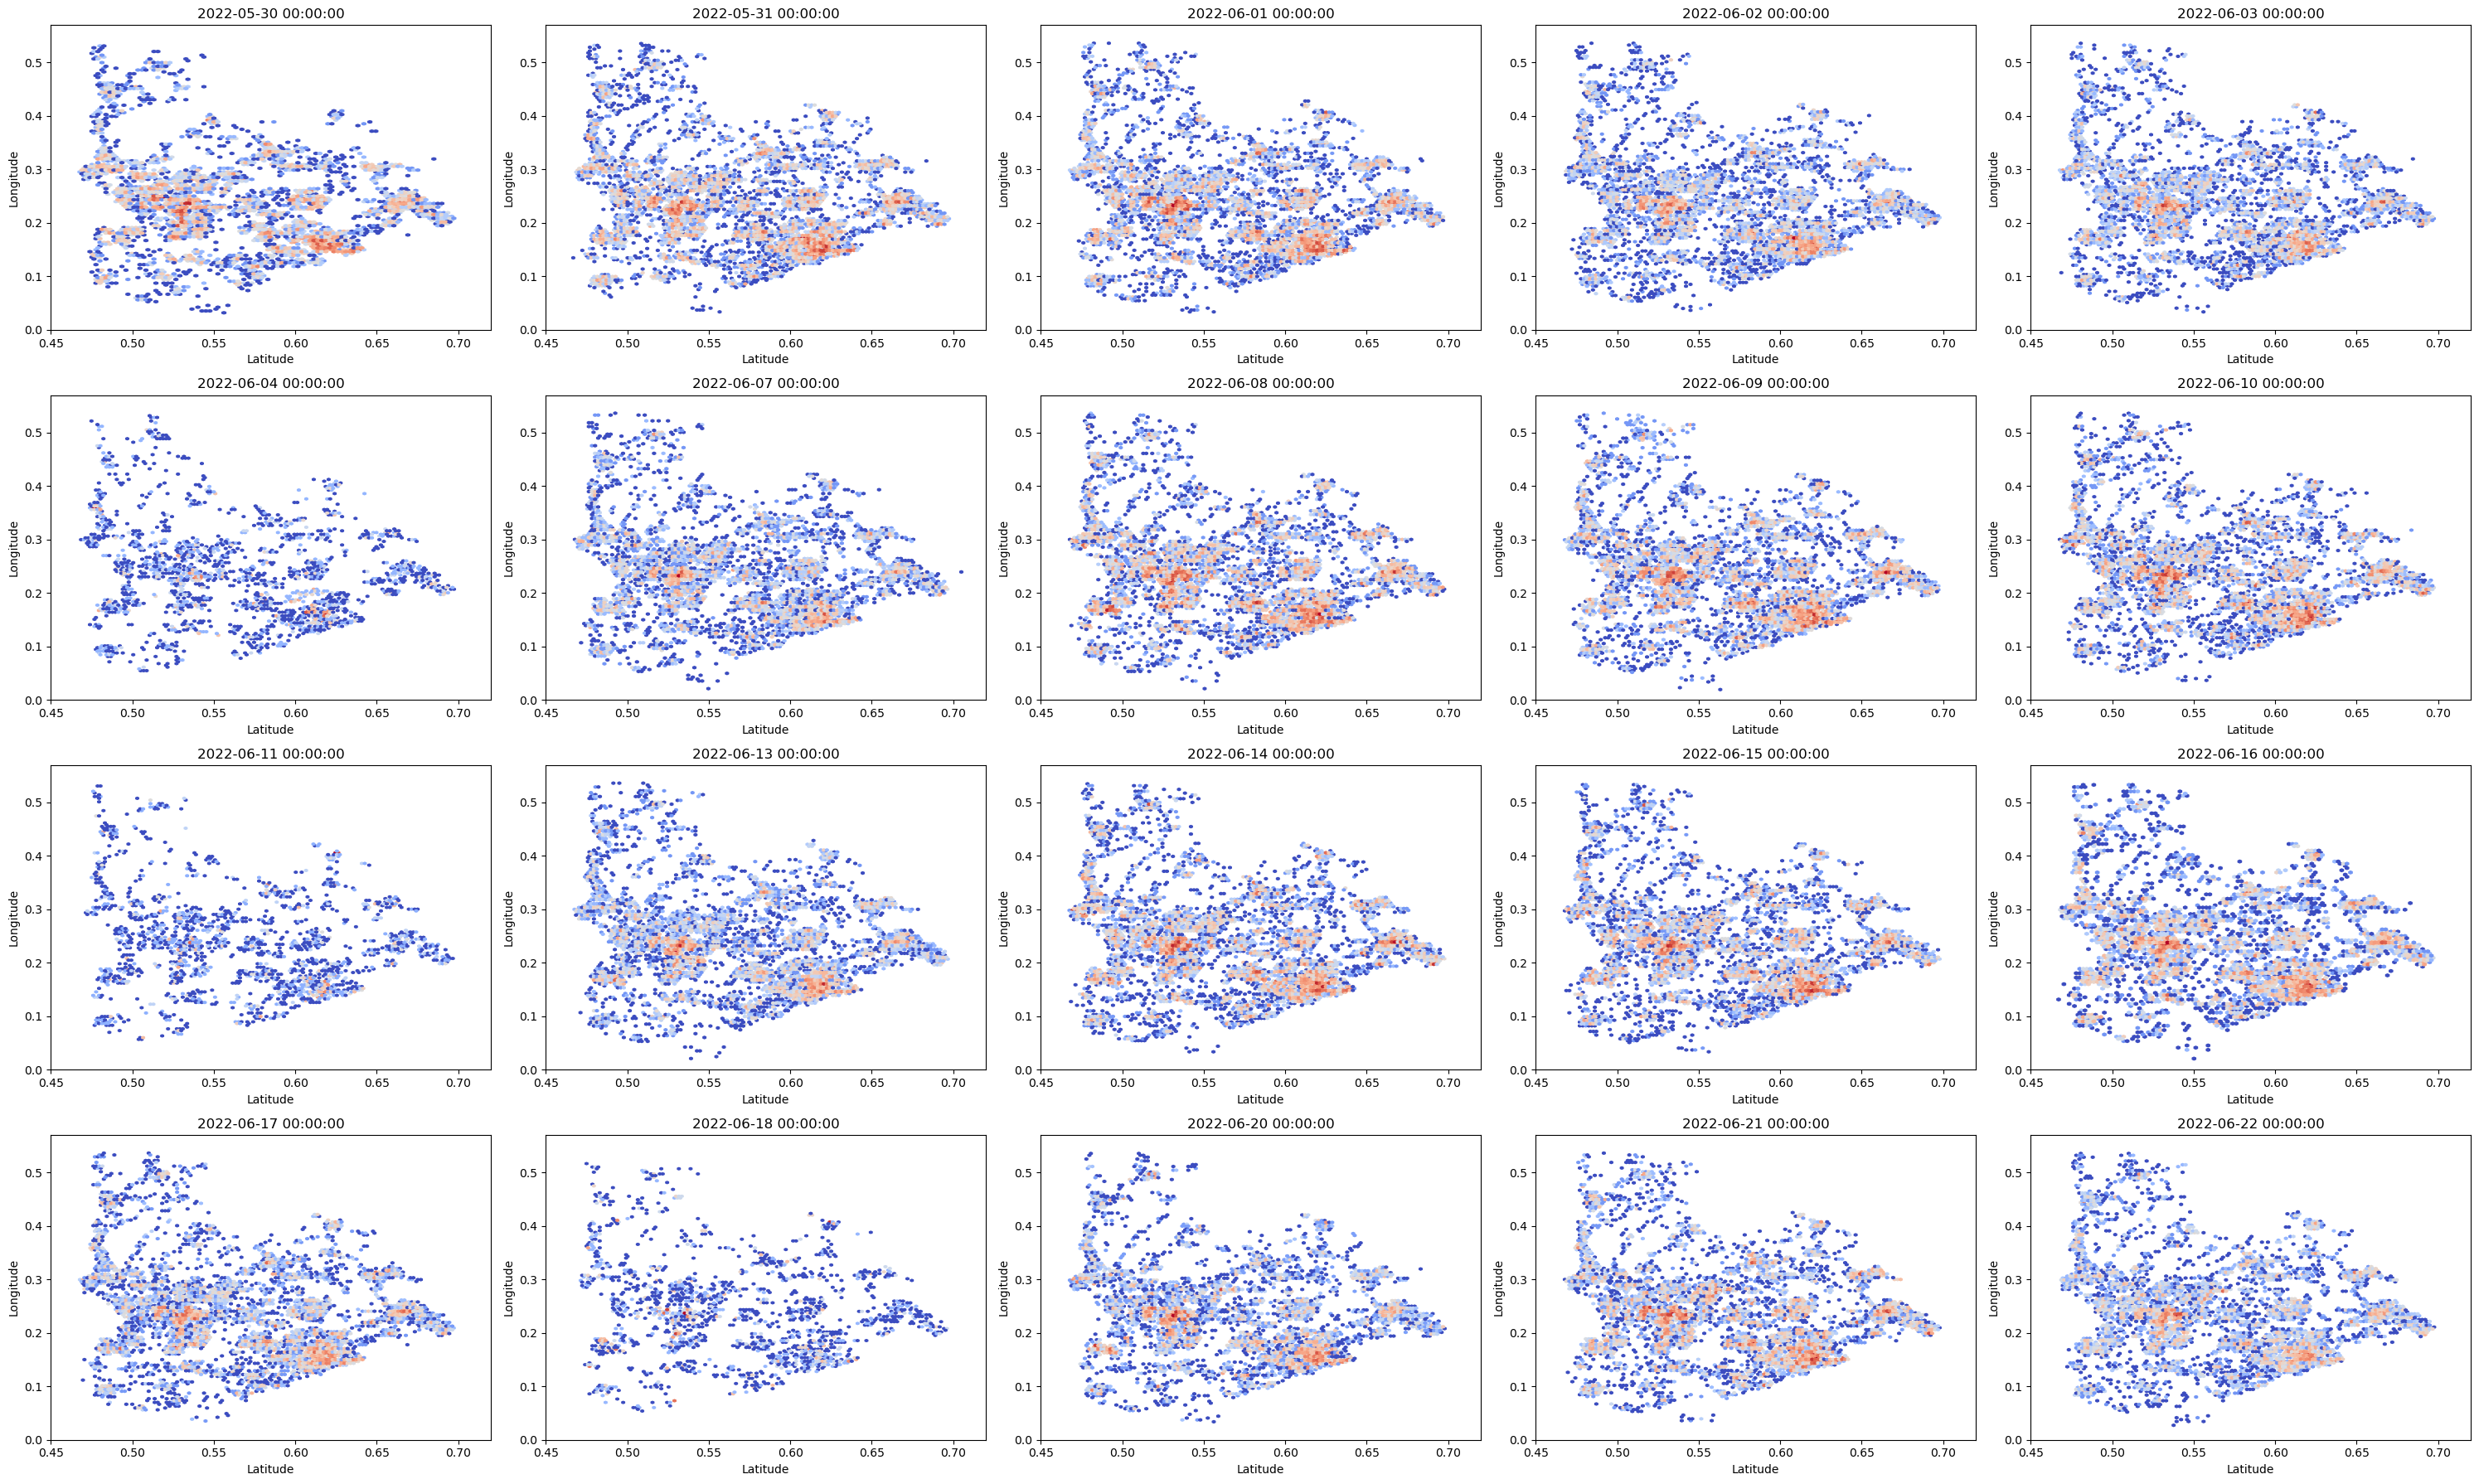

In [8]:
gs = 125


driven_df_sorted = driven_df.sort_values('Date')
unique_dates = sorted(driven_df_sorted['Date'].unique())

fig, axs = plt.subplots(4, 5, figsize=(30, 18))
axs = axs.flatten()
for i, day in enumerate(unique_dates):
    df = driven_df_sorted[driven_df_sorted['Date'] == day]
    ax = axs[i]
    ax.hexbin(df['lat'], df['long'], gridsize=gs, cmap="coolwarm", bins="log")
    ax.set_xlim(0.45, 0.72)
    ax.set_ylim(0, 0.57)
    ax.set_title(str(day))  # Convert date to string if needed
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.grid(False)

plt.tight_layout()

In [9]:
def cluster_points(points, n_clusters):
    """
    Clusters 2D points into exactly n_clusters, good for non-spherical, bunched-up groups.

    Args:
        points (array-like): List or array of 2D points [(x, y), ...].
        n_clusters (int): Number of clusters to find.

    Returns:
        np.ndarray: Array of cluster labels for each point.
    """
    points = np.array(points)

    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='single',  # good for chaining tightly packed points
    )

    labels = model.fit_predict(points)
    return labels


def cluster_kmeans(points, n_clusters):
    points_np = np.array(points)
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(points_np)
    return labels

def partition(coords, max_points=200):
    """
    Recursively partitions a list of (lat, lon) coordinates into clusters
    of at most `max_points` using axis-aligned splitting.

    Args:
        coords (list or np.ndarray): List/array of (lat, lon) points.
        max_points (int): Maximum number of points per cluster.

    Returns:
        List of np.ndarrays, each of shape (<=max_points, 2)
    """
    coords = np.array(coords)
    
    def split_recursive(points, depth=0):
        if len(points) <= max_points:
            return [points]

        # Alternate splitting axis: 0 for lat, 1 for lon
        axis = depth % 2
        sorted_points = points[points[:, axis].argsort()]
        median_index = len(sorted_points) // 2

        left = sorted_points[:median_index]
        right = sorted_points[median_index:]

        return split_recursive(left, depth + 1) + split_recursive(right, depth + 1)

    return split_recursive(coords)

In [10]:
clustered_df = []
for i, day in enumerate(unique_dates):
    df = driven_df_sorted[driven_df_sorted['Date'] == day].copy()
    available_cars = df.route_id.nunique()
    points = list(zip(df['lat'], df['long']))
    clusters = cluster_points(points, available_cars)
    km_clusters = cluster_kmeans(points, available_cars)
    df['clusterid_agg'] = clusters
    df['cluster_km'] = km_clusters
    clustered_df.append(df)    
clustered_df = pd.concat(clustered_df)

In [35]:
#points are now assigned to routes see how imbalanced these routes are
for day, df in clustered_df.groupby('Date'): 
    print(day, df.clusterid_agg.value_counts().min(), df.clusterid_agg.value_counts().max(), df.clusterid_agg.value_counts().mean())
    print(day, df.cluster_km.value_counts().min(), df.cluster_km.value_counts().max(), df.cluster_km.value_counts().mean())

2022-05-30 00:00:00 1 11142 118.64233576642336
2022-05-30 00:00:00 2 346 118.64233576642336
2022-05-31 00:00:00 1 18670 134.07853403141362
2022-05-31 00:00:00 8 371 134.07853403141362
2022-06-01 00:00:00 1 19101 122.109375
2022-06-01 00:00:00 11 285 122.109375
2022-06-02 00:00:00 1 15431 111.77604166666667
2022-06-02 00:00:00 8 258 111.77604166666667
2022-06-03 00:00:00 1 8767 102.97883597883597
2022-06-03 00:00:00 7 302 102.97883597883597
2022-06-04 00:00:00 1 2510 55.19047619047619
2022-06-04 00:00:00 5 133 55.19047619047619
2022-06-07 00:00:00 1 6876 93.2784090909091
2022-06-07 00:00:00 8 265 93.2784090909091
2022-06-08 00:00:00 1 9270 128.71808510638297
2022-06-08 00:00:00 7 293 128.71808510638297
2022-06-09 00:00:00 1 19395 125.28648648648648
2022-06-09 00:00:00 10 345 125.28648648648648
2022-06-10 00:00:00 1 8256 117.31413612565446
2022-06-10 00:00:00 7 328 117.31413612565446
2022-06-11 00:00:00 1 903 45.58904109589041
2022-06-11 00:00:00 8 121 45.58904109589041
2022-06-13 00:00:

## MULTI STEP CLUSTERING: Unattended

In [135]:
def calculate_centroid(coords):
    """Function that calculates the center of a small subset of points"""
    sum_x = sum(coord[0] for coord in coords)
    sum_y = sum(coord[1] for coord in coords)
    centroid_x = sum_x / len(coords)
    centroid_y = sum_y / len(coords)

    return (centroid_x, centroid_y)

In [136]:
driven_df.Date.unique()

array(['2022-06-17 00:00:00', '2022-05-30 00:00:00',
       '2022-05-31 00:00:00', '2022-06-01 00:00:00',
       '2022-06-02 00:00:00', '2022-06-03 00:00:00',
       '2022-06-07 00:00:00', '2022-06-08 00:00:00',
       '2022-06-09 00:00:00', '2022-06-10 00:00:00',
       '2022-06-13 00:00:00', '2022-06-14 00:00:00',
       '2022-06-15 00:00:00', '2022-06-16 00:00:00',
       '2022-06-18 00:00:00', '2022-06-20 00:00:00',
       '2022-06-21 00:00:00', '2022-06-22 00:00:00',
       '2022-06-11 00:00:00', '2022-06-04 00:00:00'], dtype=object)

In [137]:
# CONFIG FOR MULTISTEP CLUSTERING: 
day = '2022-06-21 00:00:00'     #what day do you want to make a cluster attempt for?

maxroutes = driven_df.query('Date == @day').route_id.nunique()                  #how many cars are available (we take routecount from driven_df for Date == day)
maxstops = max(driven_df.query('Date == @day').route_id.value_counts())         #how many stops are maximum allowed per route?

In [138]:
df = driven_df.query('Date == @day')
points = list(zip(df['lat'], df['long']))

In [139]:
partitions = partition(points, 20)
print(len(partitions))

2048


In [140]:
partitiondata = {}
i = 1
for p in partitions: 
    pdata = {
        'partitionId': i,
        'count': len(p), 
        'partition_points': p, 
        'partition_center': calculate_centroid(p)
    }
    partitiondata[i] = pdata
    i+=1


In [141]:



def euclidean_distance(center1, center2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2)

def calculate_centroid(points):
    """Calculate the centroid (mean) of a list of points."""
    x_sum = sum([point[0] for point in points])
    y_sum = sum([point[1] for point in points])
    return (x_sum / len(points), y_sum / len(points))

def merge_partitions(partitions, max_stops_per_route, max_clusters=200):
    merged_partitions = partitions.copy()
    
    def find_closest_pair():
        """Looks for the other value with a closest center without exceeding the max_stops_per_route arg"""
        closest_pair = None
        min_distance = float('inf')
        
        # Check all pairs of partitions
        partition_ids = list(merged_partitions.keys())
        for i in range(len(partition_ids)):
            for j in range(i + 1, len(partition_ids)):
                id1, id2 = partition_ids[i], partition_ids[j]
                center1 = merged_partitions[id1]['partition_center']
                center2 = merged_partitions[id2]['partition_center']
                dist = euclidean_distance(center1, center2)
                
                # Calculate the new count if we were to merge these partitions
                new_count = merged_partitions[id1]['count'] + merged_partitions[id2]['count']
                
                # If they are closer and merging them won't exceed max_count
                if dist < min_distance and new_count <= max_stops_per_route:
                    min_distance = dist
                    closest_pair = (id1, id2)
        
        return closest_pair
    
    # Keep merging until we reach max_clusters or cannot merge further
    while len(merged_partitions) > max_clusters:
        print(len(merged_partitions), ' ', end='\r')
        # Find the closest pair of partitions
        closest_pair = find_closest_pair()
        
        if not closest_pair:
            break  # No more valid merges possible
        
        id1, id2 = closest_pair
        partition1 = merged_partitions[id1]
        partition2 = merged_partitions[id2]
        
        # Merge the partitions
        new_count = partition1['count'] + partition2['count']
        merged_points = list(partition1['partition_points']) + list(partition2['partition_points'])
        new_center = calculate_centroid(merged_points)

        # Create a new merged partition
        new_partition = {
            'partitionId': min(id1, id2),
            'count': new_count,
            'partition_points': merged_points,
            'partition_center': new_center
        }
        
        # Remove the old partitions and add the new one
        del merged_partitions[id1]
        del merged_partitions[id2]
        merged_partitions[new_partition['partitionId']] = new_partition
    
    return merged_partitions

shrunken_partitions = merge_partitions(partitiondata, max_stops_per_route=maxstops, max_clusters = maxroutes)

In [146]:
#Thank you chatgpt
def euclidean_distance(p1, p2):
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def create_distance_matrix(points):
    size = len(points)
    matrix = [[0] * size for _ in range(size)]
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = euclidean_distance(points[i], points[j])
    return matrix

def solve_tsp(points):
    # Identify the most southwest point
    start_index = min(range(len(points)), key=lambda i: (points[i][1], points[i][0]))

    distance_matrix = create_distance_matrix(points)
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, start_index)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return int(distance_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)] * 1000)  # scale to int

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        index = routing.Start(0)
        route = []
        total_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(points[node_index])
            next_index = solution.Value(routing.NextVar(index))
            total_distance += distance_matrix[node_index][manager.IndexToNode(next_index)]
            index = next_index
        return total_distance, route
    else:
        return None, []

In [147]:
# Print the result
shrunken_partition_distances = {}



for partition_id, partition_data in shrunken_partitions.items():
    print(f"Partition ID: {partition_id}, Count: {partition_data['count']}, Center: {partition_data['partition_center']}")
    distance, route = solve_tsp(partition_data['partition_points'])
    shrunken_partition_distances[partition_id] = distance

print(len(shrunken_partitions))


Partition ID: 321, Count: 10, Center: (0.5445076072549873, 0.0690886766596018)
Partition ID: 339, Count: 11, Center: (0.5625616490258253, 0.1094104911116735)
Partition ID: 688, Count: 11, Center: (0.4802047354698429, 0.5093752055423106)
Partition ID: 936, Count: 11, Center: (0.5236155761079038, 0.4013256850314127)
Partition ID: 994, Count: 11, Center: (0.5481008371261309, 0.3256923825729526)
Partition ID: 1000, Count: 11, Center: (0.554259822013024, 0.3079503572276996)
Partition ID: 1003, Count: 11, Center: (0.5433463695713672, 0.46073168806628123)
Partition ID: 1775, Count: 11, Center: (0.6017418845231308, 0.3676350079276461)
Partition ID: 1982, Count: 11, Center: (0.6423231758187835, 0.3856245352325637)
Partition ID: 1787, Count: 33, Center: (0.612729912655831, 0.4191975292879253)
Partition ID: 1707, Count: 22, Center: (0.5772093837497586, 0.3626364897667981)
Partition ID: 687, Count: 22, Center: (0.4803235220739723, 0.4902222990869861)
Partition ID: 1019, Count: 22, Center: (0.56133

In [148]:
distances_of_original_routes = {}

#df is the same day as the data we tried to optimze
for route_id, route_day_df in df.groupby('route_id'): 
    points = list(zip(route_day_df['lat'], route_day_df['long']))
    distance, route = solve_tsp(points)
    distances_of_original_routes[route_id] = distance
    

In [149]:
print("Original mean distances", np.mean(list(distances_of_original_routes.values())))
print("Optimized mean distances", np.mean(list(shrunken_partition_distances.values())))

Original mean distances 0.13325323556398655
Optimized mean distances 0.14579095560372674


agglomerative clustering is just a bad idea; you get this kind of heavy imbalances. Kmeans ain't so bad. Iterative clustering is promissing. 